In [6]:
!pip install matplotlib seaborn pandas openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. Importação e Configuração
Primeiro, importamos as bibliotecas necessárias e configuramos o estilo dos gráficos para ficarem apresentáveis no relatório.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual para gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Exibir todas as colunas ao mostrar dataframes
pd.set_option('display.max_columns', None)

# 2. Carga e Limpeza de Dados (ETL)
Aqui resolvemos o problema dos preços formatados com vírgula (ex: "13,25") e preparamos as chaves de ligação.

In [25]:
# Carregamento dos dados
df_sales = pd.read_csv('pizza_sales.csv')
df_types = pd.read_csv('pizza_types.csv')

# --- LIMPEZA DE DADOS (CRÍTICO) ---

# A pizza_sales mostra o unit_price no formato "13,25". Python precisa de "13.25"
if df_sales['unit_price'].dtype == 'object':
    df_sales['unit_price'] = df_sales['unit_price'].astype(str).str.replace(',', '.').astype(float)

# O formato do order_date no pizza_sales varia (1/1/2015 e 13-01-2015), então usamos infer_datetime_format
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'], dayfirst=True, errors='coerce')
df_sales['order_time'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S', errors='coerce').dt.hour

# Na tabela pizza_sales temos 'hawaiian_m', na pizza_types temos 'hawaiian'. Vamos remover o tamanho (_s, _m, _l) para pegar o tipo.
df_sales['pizza_type_id'] = df_sales['pizza_name_id'].apply(lambda x: x.rsplit('_', 1)[0])

# Visualizar as primeiras linhas limpas
display(df_sales.head())

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,pizza_type_id
0,1,1,hawaiian_m,1,2015-01-01,11,13.25,M,hawaiian
1,2,2,classic_dlx_m,1,2015-01-01,11,16.00,M,classic_dlx
2,3,2,five_cheese_l,1,2015-01-01,11,18.50,L,five_cheese
3,4,2,ital_supr_l,1,2015-01-01,11,20.75,L,ital_supr
4,5,2,mexicana_m,1,2015-01-01,11,16.00,M,mexicana


# 3. Cruzamento e Engenharia de Atributos
Cruzamos as vendas com os tipos para trazer informações valiosas como Categoria e Ingredientes. Calculamos também a receita total, pois o foco é lucratividade

In [26]:
# Trazendo Category e Ingredients para a tabela de vendas
df_merged = pd.merge(df_sales, df_types, on='pizza_type_id', how='left')

# Cálculo de Receita (Faturamento Bruto)
df_merged['revenue'] = df_merged['quantity'] * df_merged['unit_price']

# Verificando se o merge funcionou (não deve haver nulos em pizza_category)
print(f"Total de Vendas Analisadas: {len(df_merged)}")
display(df_merged[['order_id', 'pizza_name', 'pizza_category', 'revenue', 'pizza_ingredients']].head(3))

Total de Vendas Analisadas: 48620


,order_id,pizza_name,pizza_category,revenue,pizza_ingredients
0,1,The Hawaiian Pizza,Classic,13.25,"Sliced Ham, Pineapple, Mozzarella Cheese"
1,2,The Classic Deluxe Pizza,Classic,16.00,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
2,2,The Five Cheese Pizza,Veggie,18.50,"Mozzarella Cheese, Provolone Cheese, Smoked Go..."


# 4. Análise Estratégica: "O Que Vende?"
Essa célula gera a tabela para identificar as pizzas que mais saem e as que menos saem (baixa performance).


--- TOP 5 PIZZAS (Receita) ---


,pizza_name,pizza_category,revenue,quantity,order_id,pct_revenue,accum_revenue
30,The Thai Chicken Pizza,Chicken,43434.25,2371,2225,5.310719,5.310719
0,The Barbecue Chicken Pizza,Chicken,42768.00,2432,2273,5.229257,10.539976
4,The California Chicken Pizza,Chicken,41409.50,2370,2197,5.063152,15.603128
7,The Classic Deluxe Pizza,Classic,38180.50,2453,2329,4.668341,20.271469
26,The Spicy Italian Pizza,Supreme,34831.25,1924,1822,4.258828,24.530297



--- BOTTOM 5 PIZZAS (Candidatas a Remoção) ---


,pizza_name,pizza_category,revenue,quantity,order_id,pct_revenue,accum_revenue
27,The Spinach Pesto Pizza,Veggie,15596.00,970,945,1.906928,93.130548
16,The Mediterranean Pizza,Veggie,15360.50,934,912,1.878133,95.008681
28,The Spinach Supreme Pizza,Supreme,15277.75,950,918,1.868015,96.876697
11,The Green Garden Pizza,Veggie,13955.75,997,976,1.706374,98.583071
2,The Brie Carre Pizza,Supreme,11588.50,490,480,1.416929,100.000000


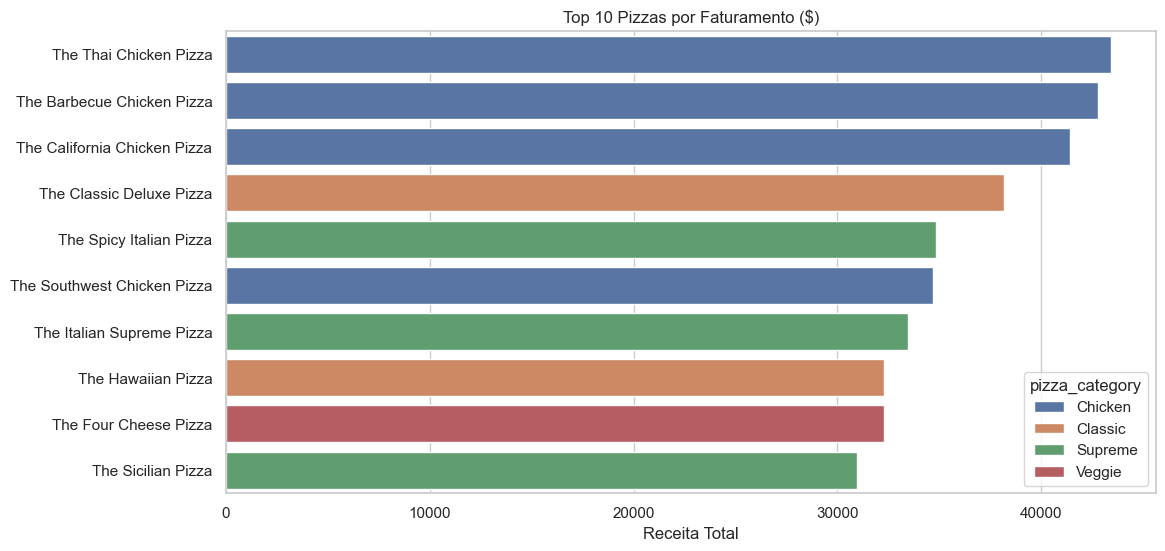

In [27]:
# Agrupamento por nome da pizza
analise_produto = df_merged.groupby(['pizza_name', 'pizza_category']).agg({
    'revenue': 'sum',
    'quantity': 'sum',
    'order_id': 'nunique'
}).reset_index()

# Ordenar por receita
analise_produto = analise_produto.sort_values(by='revenue', ascending=False)

# Adicionar % acumulada
analise_produto['pct_revenue'] = (analise_produto['revenue'] / analise_produto['revenue'].sum()) * 100
analise_produto['accum_revenue'] = analise_produto['pct_revenue'].cumsum()

# Exibindo os extremos
print("\n--- TOP 5 PIZZAS (Receita) ---")
display(analise_produto.head(5))

print("\n--- BOTTOM 5 PIZZAS (Candidatas a Remoção) ---")
display(analise_produto.tail(5))

# Gráfico de Barras: Top 10 Pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=analise_produto.head(10), x='revenue', y='pizza_name', hue='pizza_category', dodge=False)
plt.title('Top 10 Pizzas por Faturamento ($)')
plt.xlabel('Receita Total')
plt.ylabel('')
plt.show()

# 5. Análise Operacional: "Quando Vende?"
Aqui a intenção é identificar horários de pico e ociosidade, permitindo ajustes futuros de turnos da equipe.

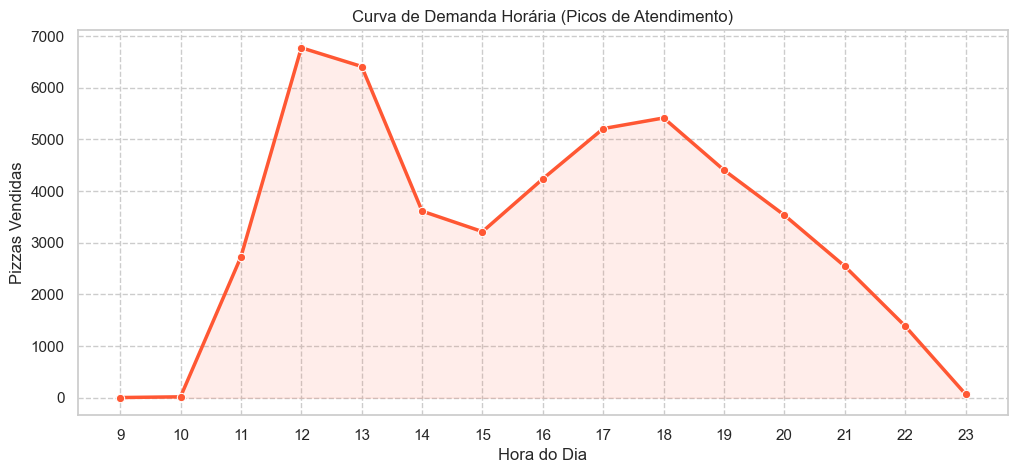

In [28]:
# Agrupamento por hora do dia
vendas_por_hora = df_merged.groupby('order_time')['quantity'].sum().reset_index()

# Visualização
plt.figure(figsize=(12,5))
sns.lineplot(data=vendas_por_hora, x='order_time', y='quantity', marker='o', linewidth=2.5, color='#FF5733')
plt.fill_between(vendas_por_hora['order_time'], vendas_por_hora['quantity'], alpha=0.1, color='#FF5733')

plt.title('Curva de Demanda Horária (Picos de Atendimento)')
plt.xlabel('Hora do Dia')
plt.ylabel('Pizzas Vendidas')
plt.xticks(range(9, 24))
plt.grid(True, linestyle='--')
plt.show()

# 6. Oportunidade: Ingredientes e Categorias
Aqui analisamos a eficiência do cardápio cruzando ingredientes com categorias.

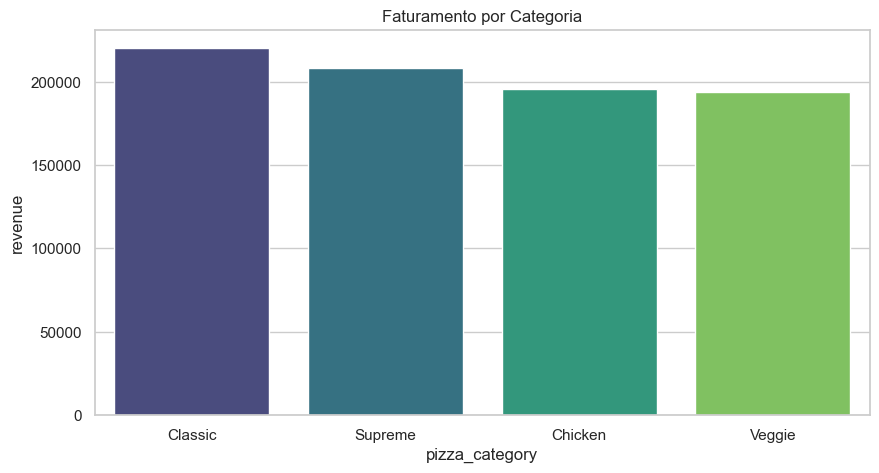

In [29]:
# Receita por Categoria
plt.figure(figsize=(10,5))
category_rev = df_merged.groupby('pizza_category')['revenue'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=category_rev, x='pizza_category', y='revenue', palette='viridis', hue='pizza_category', legend=False)
plt.title('Faturamento por Categoria')
plt.show()

# 7. Análise de Risco (Ingredientes Premium vs. Vendas)
Essa célula busca palavras-chave de alto valor (como Brie, Prosciutto, Goat Cheese) na coluna pizza_ingredients e verifica o volume de vendas dessas pizzas na tabela pizza_sales

In [30]:
# Lista de ingredientes tipicamente caros/perecíveis (baseado em conhecimento de mercado). Estes ingredientes aumentam o CMV e o risco de desperdício se o giro for baixo.
ingredientes_premium = [
    'Brie', 'Prosciutto', 'Goat Cheese', 'Fontina', 
    'Gorgonzola', 'Pesto', 'Artichoke'
]

print(f"--- Análise de Risco: Ingredientes Premium ---")

# Criar uma lista para armazenar os resultados
analise_risco = []

for ingrediente in ingredientes_premium:
    # Filtra pizzas que contém o ingrediente na string 'pizza_ingredients'
    pizzas_com_ingrediente = df_merged[df_merged['pizza_ingredients'].str.contains(ingrediente, case=False, na=False)]
    
    # Agrupa para pegar estatísticas de venda dessas pizzas
    resumo = pizzas_com_ingrediente.groupby('pizza_name').agg({
        'quantity': 'sum',
        'revenue': 'sum',
        'unit_price': 'mean',
        'pizza_ingredients': 'first' # Pega a lista de ingredientes para conferência
    }).reset_index()
    
    resumo['ingrediente_foco'] = ingrediente
    analise_risco.append(resumo)

# Consolida todos os resultados em um único DF
df_risco = pd.concat(analise_risco).drop_duplicates(subset=['pizza_name', 'ingrediente_foco'])

# Ingredientes Caros com BAIXA venda (menor Quantity primeiro)
df_risco = df_risco.sort_values(by=['quantity'], ascending=True)

# Exibe o relatório
display(df_risco[['ingrediente_foco', 'pizza_name', 'quantity', 'revenue', 'unit_price']])

# --- Insight Automático ---
pior_performance = df_risco.iloc[0]
print(f"\n[ALERTA CONSULTORIA] O item de maior risco é a '{pior_performance['pizza_name']}'.")
print(f"Ela usa '{pior_performance['ingrediente_foco']}' mas vendeu apenas {pior_performance['quantity']} unidades no período analisado.")

--- Análise de Risco: Ingredientes Premium ---


,ingrediente_foco,pizza_name,quantity,revenue,unit_price
0,Brie,The Brie Carre Pizza,490,11588.50,23.650000
0,Prosciutto,The Brie Carre Pizza,490,11588.50,23.650000
2,Artichoke,The Mediterranean Pizza,934,15360.50,16.427952
5,Artichoke,The Spinach Supreme Pizza,950,15277.75,16.089362
1,Fontina,The Soppressata Pizza,961,16425.75,17.077064
2,Pesto,The Spinach Pesto Pizza,970,15596.00,16.079676
4,Artichoke,The Spinach Pesto Pizza,970,15596.00,16.079676
0,Pesto,The Chicken Pesto Pizza,973,16701.75,17.153746
1,Pesto,The Italian Vegetables Pizza,981,16019.25,16.339231
1,Artichoke,The Italian Vegetables Pizza,981,16019.25,16.339231



[ALERTA CONSULTORIA] O item de maior risco é a 'The Brie Carre Pizza'.
Ela usa 'Brie' mas vendeu apenas 490 unidades no período analisado.
